In [2]:
import deepcompton
import os
import numpy as np
import matplotlib.pyplot as plt
print(os.getcwd())

data_dir = "../save_Compton"
if not os.path.exists(data_dir):
    print("Could not find data directory {}".format(data_dir))

/home/aschulz/Documents/python/astroinfo2021/compton-hackathon/DeepIntegralCompton/examples


In [3]:
# instrument caracteristics
z_isgri = 0.
z_picsit = -8.68

In [ ]:
# first we need to create the dataset used for training and testing
from deepcompton.cones import make_cone_density
def make_dataset(datadir, max_n = 1000):
    y,x=[],[]
    for f in os.listdir(datadir):
        _,theta,_,phi=f.replace(".npy","").split("_")
        data = make_cone_density(theta, phi, z_isgri, z_picsit, datadir=datadir, progress=False)
        if data is not None:
            y.append([float(theta),float(phi)])
            x.append(data.reshape(180,45,1))
        if len(y)==max_n:
            break
        print(len(y))
    return np.array(x),np.array(y)
# pickled data
pkl_filename = "../cone_density_data_full_2.pkl"
if os.path.exists(pkl_filename) and False:
    import pickle as pkl
    y,x=pkl.load(open(pkl_filename,"rb"))
    def clean_pkl_data(x,y):
        a,b=[],[]
        for i in range(len(x)):
            if x[i] is not None:
                a.append(x[i].reshape(180,45,1))
                b.append(np.array([float(y[i][0]),float(y[i][1])]))
        return np.array(a),np.array(b)
    x,y = clean_pkl_data(x,y)
    
else:
    x,y = make_dataset(data_dir)
    pkl.dump((x,y),open(pkl_filename,"wb"))
print(x.shape, y.shape)

1
2
3
3
4
5
6
7
7
8
9
10
11
12
13
13
14
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
52
53
54
55
56
56
57
58
59
60
61
62
63
64
65
66
67
68
68
69
70
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
167
168
169
170
171
171
172
173
174
175
175
176
177
178
178
179
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
209
210
210
211
212
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
226
227
227
228
229
230
231
232
233
234
235
236
237
238
239
239
240
241
242
242
243
244
245
246
247
248
249
250
251
252
253
253
254
255
256
25

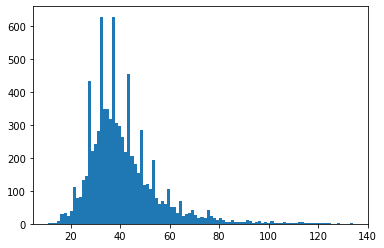

In [69]:
# plot the distribution of the data
plt.figure()
plt.hist(x[0].flatten(),bins=100)
plt.show()

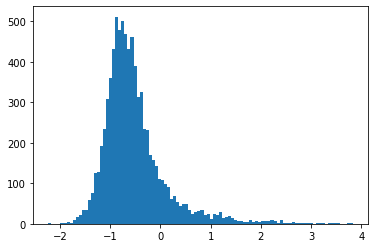

In [70]:
# normalize the data
from sklearn.preprocessing import scale
flat_x=[]
for i in range(x.shape[0]):
    flat_x.append(x[i].flatten())
flat_x=np.array(flat_x)


flat_x = scale(flat_x)

new_x = [flat_x[i].reshape(180,45,1) for i in range(flat_x.shape[0])]
new_x = np.array(new_x)
plt.figure()
plt.hist(new_x[0].flatten(),bins=100)
plt.show()

In [6]:
#from deepcompton.vizualisation import plot_backprojected
#plot_backprojected(y[0,0],y[0,1], x[0])

In [71]:
# creating the train and test data
from sklearn.model_selection import train_test_split
import tensorflow as tf
x_train,x_test, y_train,y_test = train_test_split(new_x, y, shuffle=True)

y_train,y_test = np.array(y_train), np.array(y_test)
x_train,x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# convert to tensorflow tensors
y_train = tf.convert_to_tensor(y_train)
x_train = tf.convert_to_tensor(x_train)
#y_test= tf.convert_to_tensor(y_test)
#x_test= tf.convert_to_tensor(x_test)
print("Train data : {} {}".format(x_train.shape, y_train.shape))
print("Test data  : {} {}".format(x_test.shape, y_test.shape))


(75, 180, 45, 1) (75, 2) (25, 180, 45, 1) (25, 2)
Train data : (75, 180, 45, 1) (75, 2)
Test data  : (25, 180, 45, 1) (25, 2)


In [89]:
# definition of a first convolutional model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten
def get_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32,3,input_shape=(180,45,1), activation="elu"))
    model.add(BatchNormalization())
    #model.add(Conv2D(64,3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512,activation="elu"))
    model.add(BatchNormalization())
    #model.add(Dense(128,activation="relu"))
    #model.add(BatchNormalization())
    model.add(Dense(2))
    return model

In [90]:
from deepcompton.utils import angular_separation
def angular_loss(y_true, y_pred):
    # convert to rad
    _deg2rad = np.pi / 180.
    _lat1,_lon1=y_true[-1][0]*_deg2rad,y_true[-1][1]*_deg2rad
    _lat2,_lon2=y_pred[-1][0]*_deg2rad,y_pred[-1][1]*_deg2rad
    return -1. * (tf.math.sin(_lat1)*tf.math.sin(_lat2)*
                  tf.math.cos(_lon1-_lon2)+
                  tf.math.cos(_lat2)*tf.math.cos(_lat1))
    

In [93]:
# get the model
model = get_model()

epochs = 100
batch_size = 12

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard('./logs_cnn_1_angular', update_freq=1)

]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss="mean_squared_error",
    metrics=["mean_squared_error"],
    #loss=angular_loss,
    #metrics=[angular_loss],
)

In [ ]:
model.fit(
    x_train, y_train, 
    #steps_per_epoch=epochs,
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_split = 0.2,
)

Epoch 1/100


In [85]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 25820.650390625
Test accuracy: 25820.650390625


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[0. 0.]]
[ 40. 348.]


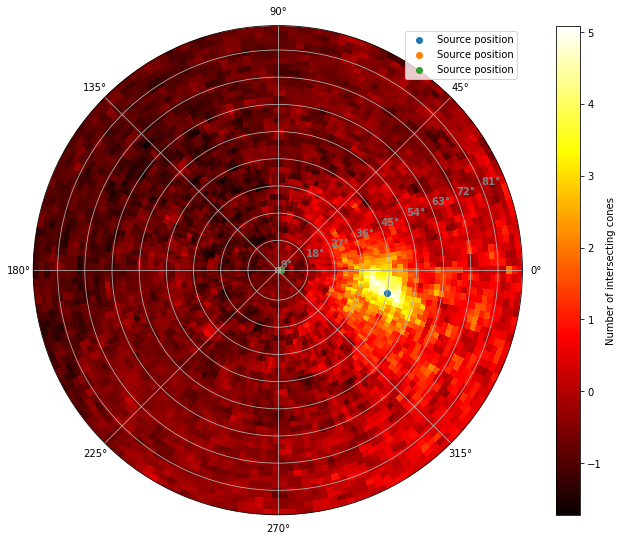

In [88]:
from deepcompton.vizualisation import plot_backprojected,plot_source_pos
i=1

actual = np.radians(np.linspace(0,360, 180))
expected = np.arange(0,90,2)
r_g, theta_g = np.meshgrid(expected, actual)
ax = plot_backprojected(theta_g, r_g, x_test[i].reshape(180,45))
ax = plot_source_pos(y_test[i,0], np.radians(y_test[i,1]), ax=ax)
pred = model(tf.reshape(x_test[i],[1,180,45,1]))
print(pred.numpy())
print(y_test[i])
ax = plot_source_pos(pred[0,0], np.radians(pred[0,1]), ax=ax)
ax = plot_source_pos(pred[0,0], np.radians(pred[0,1]), ax=ax)
